In [1]:
from models.rootspike_glm import RootSpike_GLM

import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 500
device = torch.device("cuda")
batch_size = 100000
iter_no = 20000
epoch_no = 15
lr = 0.0005

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
Z_file = "spk_loc.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
Z = torch.from_numpy(Z)
C_den = torch.from_numpy(C_den)

Z_train = Z[:T_train].float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)
sub_no = C_den.shape[0]

In [4]:
batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = RootSpike_GLM(C_den, C_syn_e, C_syn_i, T_no, device)

optimizer = torch.optim.Adam([
            {'params': model.parameters()},
            ], lr = lr)

model.to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss()

220


In [ ]:
loss_factor = 1

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_Z = Z_train[batch_idx : batch_idx+batch_size].to(device)
    
    Z_pred, out_filters = model.train_forward(batch_E_neural, batch_I_neural, batch_Z)

    bce_loss = bce_criterion(Z_pred, batch_Z)
    
    loss = bce_loss
    loss.backward()
    optimizer.step()
    
    #print(train_score)
    
    if (i%1000 == 999) or (i == iter_no-1):
        model.eval()
            
        test_Z_pred, test_L_pred, out_filters = model.test_forward(test_E_neural,test_I_neural)

        test_loss = bce_criterion(test_L_pred, Z_test)
        
        good_no = 0
        bad_no = 0
        for x in torch.where(test_Z_pred == 1)[0]:
            close_count = 0
            for y in torch.where(Z_test == 1)[0]:
                if torch.abs(x-y) <= 5:
                    close_count += 1
            if close_count > 0:
                good_no += 1
            else:
                bad_no += 1
        print(test_loss.item(), "GOOD: ", good_no, "BAD: ", bad_no)

<ipython-input-6-3b162e5f8b62>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0.020082609727978706 GOOD:  4 BAD:  783
0.01631907932460308 GOOD:  3 BAD:  522
0.01494134496897459 GOOD:  0 BAD:  415
0.016254588961601257 GOOD:  0 BAD:  344
0.01843579113483429 GOOD:  0 BAD:  293
0.020081693306565285 GOOD:  0 BAD:  246
0.020528201013803482 GOOD:  0 BAD:  225
0.020141804590821266 GOOD:  0 BAD:  242
98.90494537353516 GOOD:  462 BAD:  49119
98.96218872070312 GOOD:  462 BAD:  49128
97.95307922363281 GOOD:  462 BAD:  48650


In [7]:
final_Z = np.zeros((T_test))
sample_no = 10

for i in tnrange(10):
    test_Z_pred, test_L_pred, out_filters = model.test_forward(test_E_neural,test_I_neural)
    final_Z += test_Z_pred.cpu().detach().numpy() / sample_no

<ipython-input-7-24b7e6a48643>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10):


(0.0, 0.05)

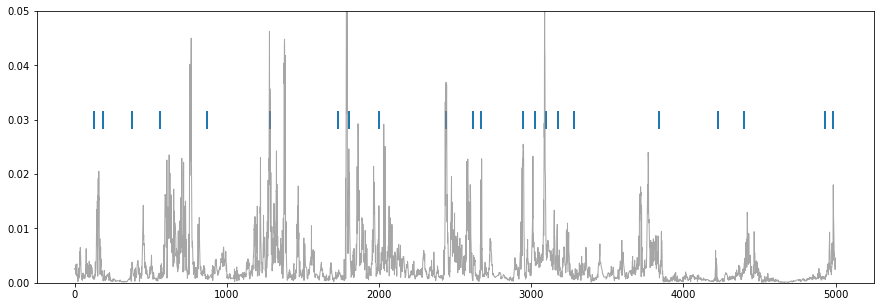

In [13]:
plt.figure(figsize = (15,5))
plt.plot(test_L_pred.cpu().detach().numpy()[20000:25000],linewidth=1,c="gray", alpha=0.7)
plt.scatter(np.arange(5000), Z_test.cpu().detach().numpy()[20000:25000]-0.97, marker="|",s=350, linewidth=2)
plt.scatter(np.arange(5000), final_Z[20000:25000]-0.96, marker="|",s=350, linewidth=2)
#LRELU BERNOULLI
plt.ylim(0,0.05)

In [8]:
t = np.arange(T_no)
t_tau = t / 8
kern = t_tau * np.exp(-t_tau)
kern = kern
kern = torch.from_numpy(kern)
kern = torch.flip(kern, [0]).reshape(1,1,-1)
final_Z = torch.from_numpy(final_Z)
out = F.conv1d(final_Z.reshape(1,1,-1).float(), kern.float()).flatten()


V_test = np.load("/media/hdd01/sklee/CA1_clust4-60/data/V_diff.npy")
V_test = V_test[T_train:T_train+T_test]

#plt.ylim(0,2.5)

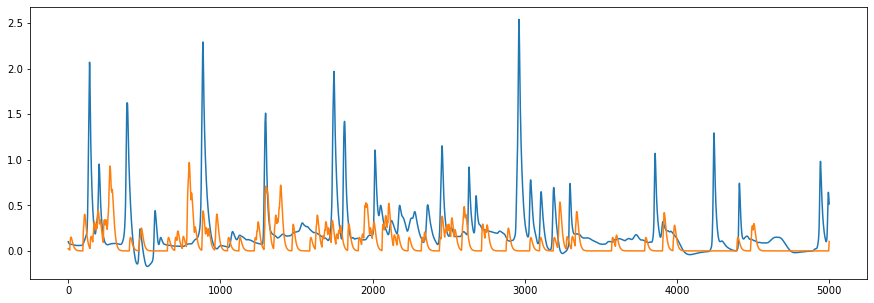

In [12]:
plt.figure(figsize = (15,5))
plt.plot(V_test[20000:25000])
plt.plot(out.cpu().detach().numpy()[20000:25000]*4)

In [11]:
print(np.diff(torch.where(Z_test == 1)[0].cpu().detach().numpy()))

[ 684  489 1214   13   59  522   26  486   66   81  435  201   64  185
  185  311  412  449   70  200  441  177   48  280   77   70   82  106
  559  387  168  532   52   61  483   57  503  546  554  202]
